# Binning 2D data and doing JV assignments
> Equally splitting 2D data with respect to their coordinates, then do JV assignment on individual blocks.

- toc: true 
- badges: true
- comments: true
- categories: [Data]


## Generate data from 2D Gaussian distribution

Here we generate random samples from a 2D Gaussian distribution
and plot the data.     



In [1]:
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from lapjv import lapjv
np.random.seed(5)

In [2]:
mean = (-4, 5)
cov = [[1, 0.8], [0.8, 1]]
N = 25471
X = np.random.multivariate_normal(mean, cov, N)

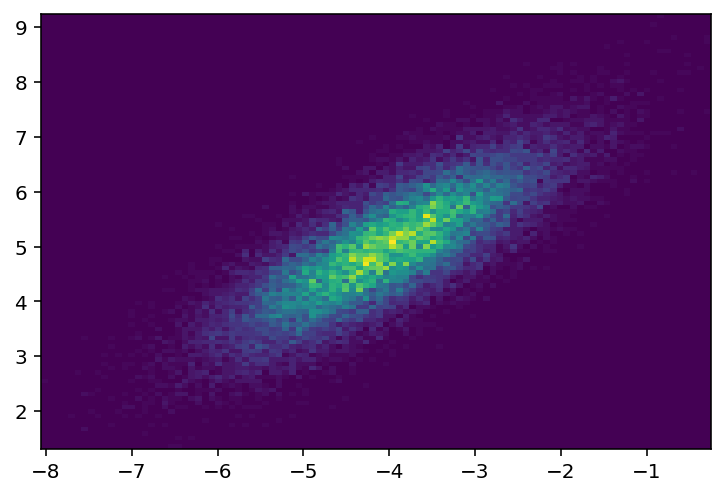

In [3]:
plt.hist2d(X[:, 0], X[:, 1], bins=100);

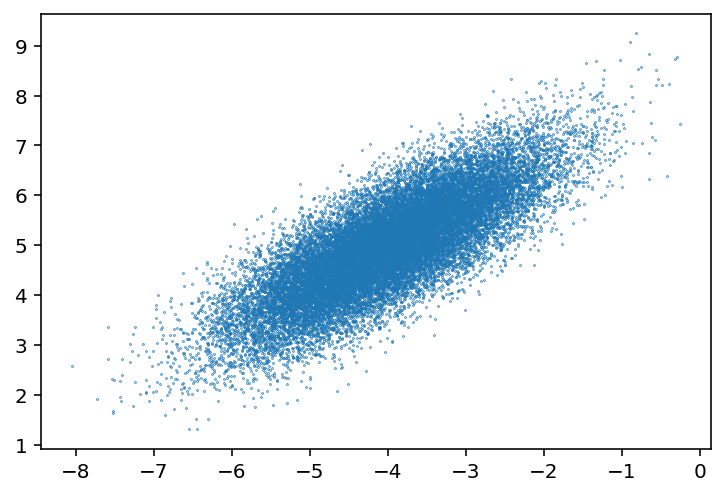

In [4]:
plt.scatter(X[:, 0], X[:, 1], s=0.1);

## Split the data by percentiles

In [5]:
df = pd.DataFrame(X, columns=['x', 'y'])

In [6]:
n_cuts = 4

In [7]:
pcts = np.linspace(0, 100, n_cuts+1)

In [8]:
pcts

array([  0.,  25.,  50.,  75., 100.])

check the global percentiles

In [9]:
pcts_x = [np.percentile(df['x'], p) for p in pcts]
pcts_y = [np.percentile(df['y'], p) for p in pcts]

In [10]:
pcts_x

[-8.056800776237175,
 -4.688114391830573,
 -4.006911789051436,
 -3.336958328368386,
 -0.25323804036638853]

In [11]:
pcts_y

[1.3164850445961904,
 4.322595717077761,
 4.996182271178584,
 5.672982753494438,
 9.244821243128097]

In [12]:
len(pcts_x), len(pcts_x)

(5, 5)

generate catogorical colors for visualisation

In [13]:
# generate a list of 16 catogorical colors
colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for _ in range(n_cuts**2)]
colors

['#933F5B',
 '#8BB5EE',
 '#917E5D',
 '#5EECD1',
 '#4C20D8',
 '#27B32C',
 '#E15209',
 '#21CDB3',
 '#B7007D',
 '#F866AA',
 '#F97865',
 '#F21DFA',
 '#8E9A13',
 '#2EA282',
 '#E64841',
 '#207798']

split the data according to the x and y percentiles

0 6368
1 6368
2 6368
3 6368


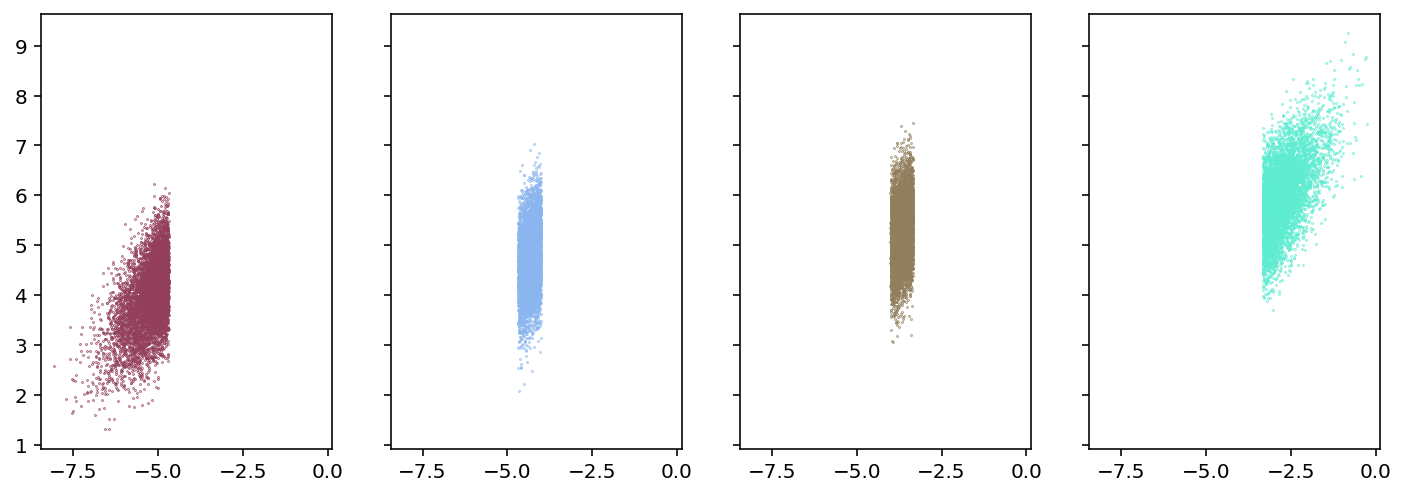

In [14]:
pcts_x = [np.percentile(df['x'], p) for p in pcts]
fig, axes = plt.subplots(1, n_cuts, figsize=(12, 4), sharex=True, sharey=True)

for i in range(n_cuts):
    di = df[(df['x']>=pcts_x[i]) & (df['x']<=pcts_x[i+1])]
    print(i, len(di))
    axes[i].scatter(di['x'], di['y'], s=0.1, color=colors[i])


0 6368
1 6368
2 6368
3 6368


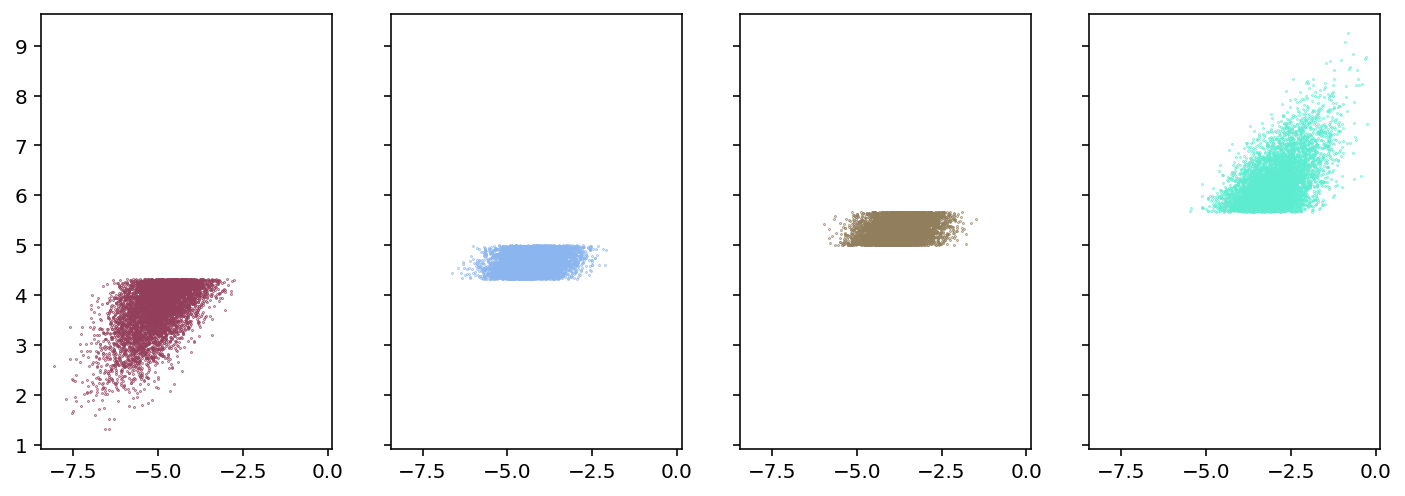

In [15]:
pcts_y = [np.percentile(df['y'], p) for p in pcts]
fig, axes = plt.subplots(1, n_cuts, figsize=(12, 4), sharex=True, sharey=True)

for j in range(n_cuts):
    dj = df[(df['y']>=pcts_y[j]) & (df['y']<=pcts_y[j+1])]
    print(j, len(dj))
    axes[j].scatter(dj['x'], dj['y'], s=0.1, color=colors[j])


split the data along one axis, then along the other axis.

Note here that when splitting the data sequentially, we can't use the overall percentiles, but the percentiles of the split data.

0 6368
0 0 0 1592
0 1 1 1592
0 2 2 1592
0 3 3 1592
1 6368
1 0 4 1592
1 1 5 1592
1 2 6 1592
1 3 7 1592
2 6368
2 0 8 1592
2 1 9 1592
2 2 10 1592
2 3 11 1592
3 6368
3 0 12 1592
3 1 13 1592
3 2 14 1592
3 3 15 1592


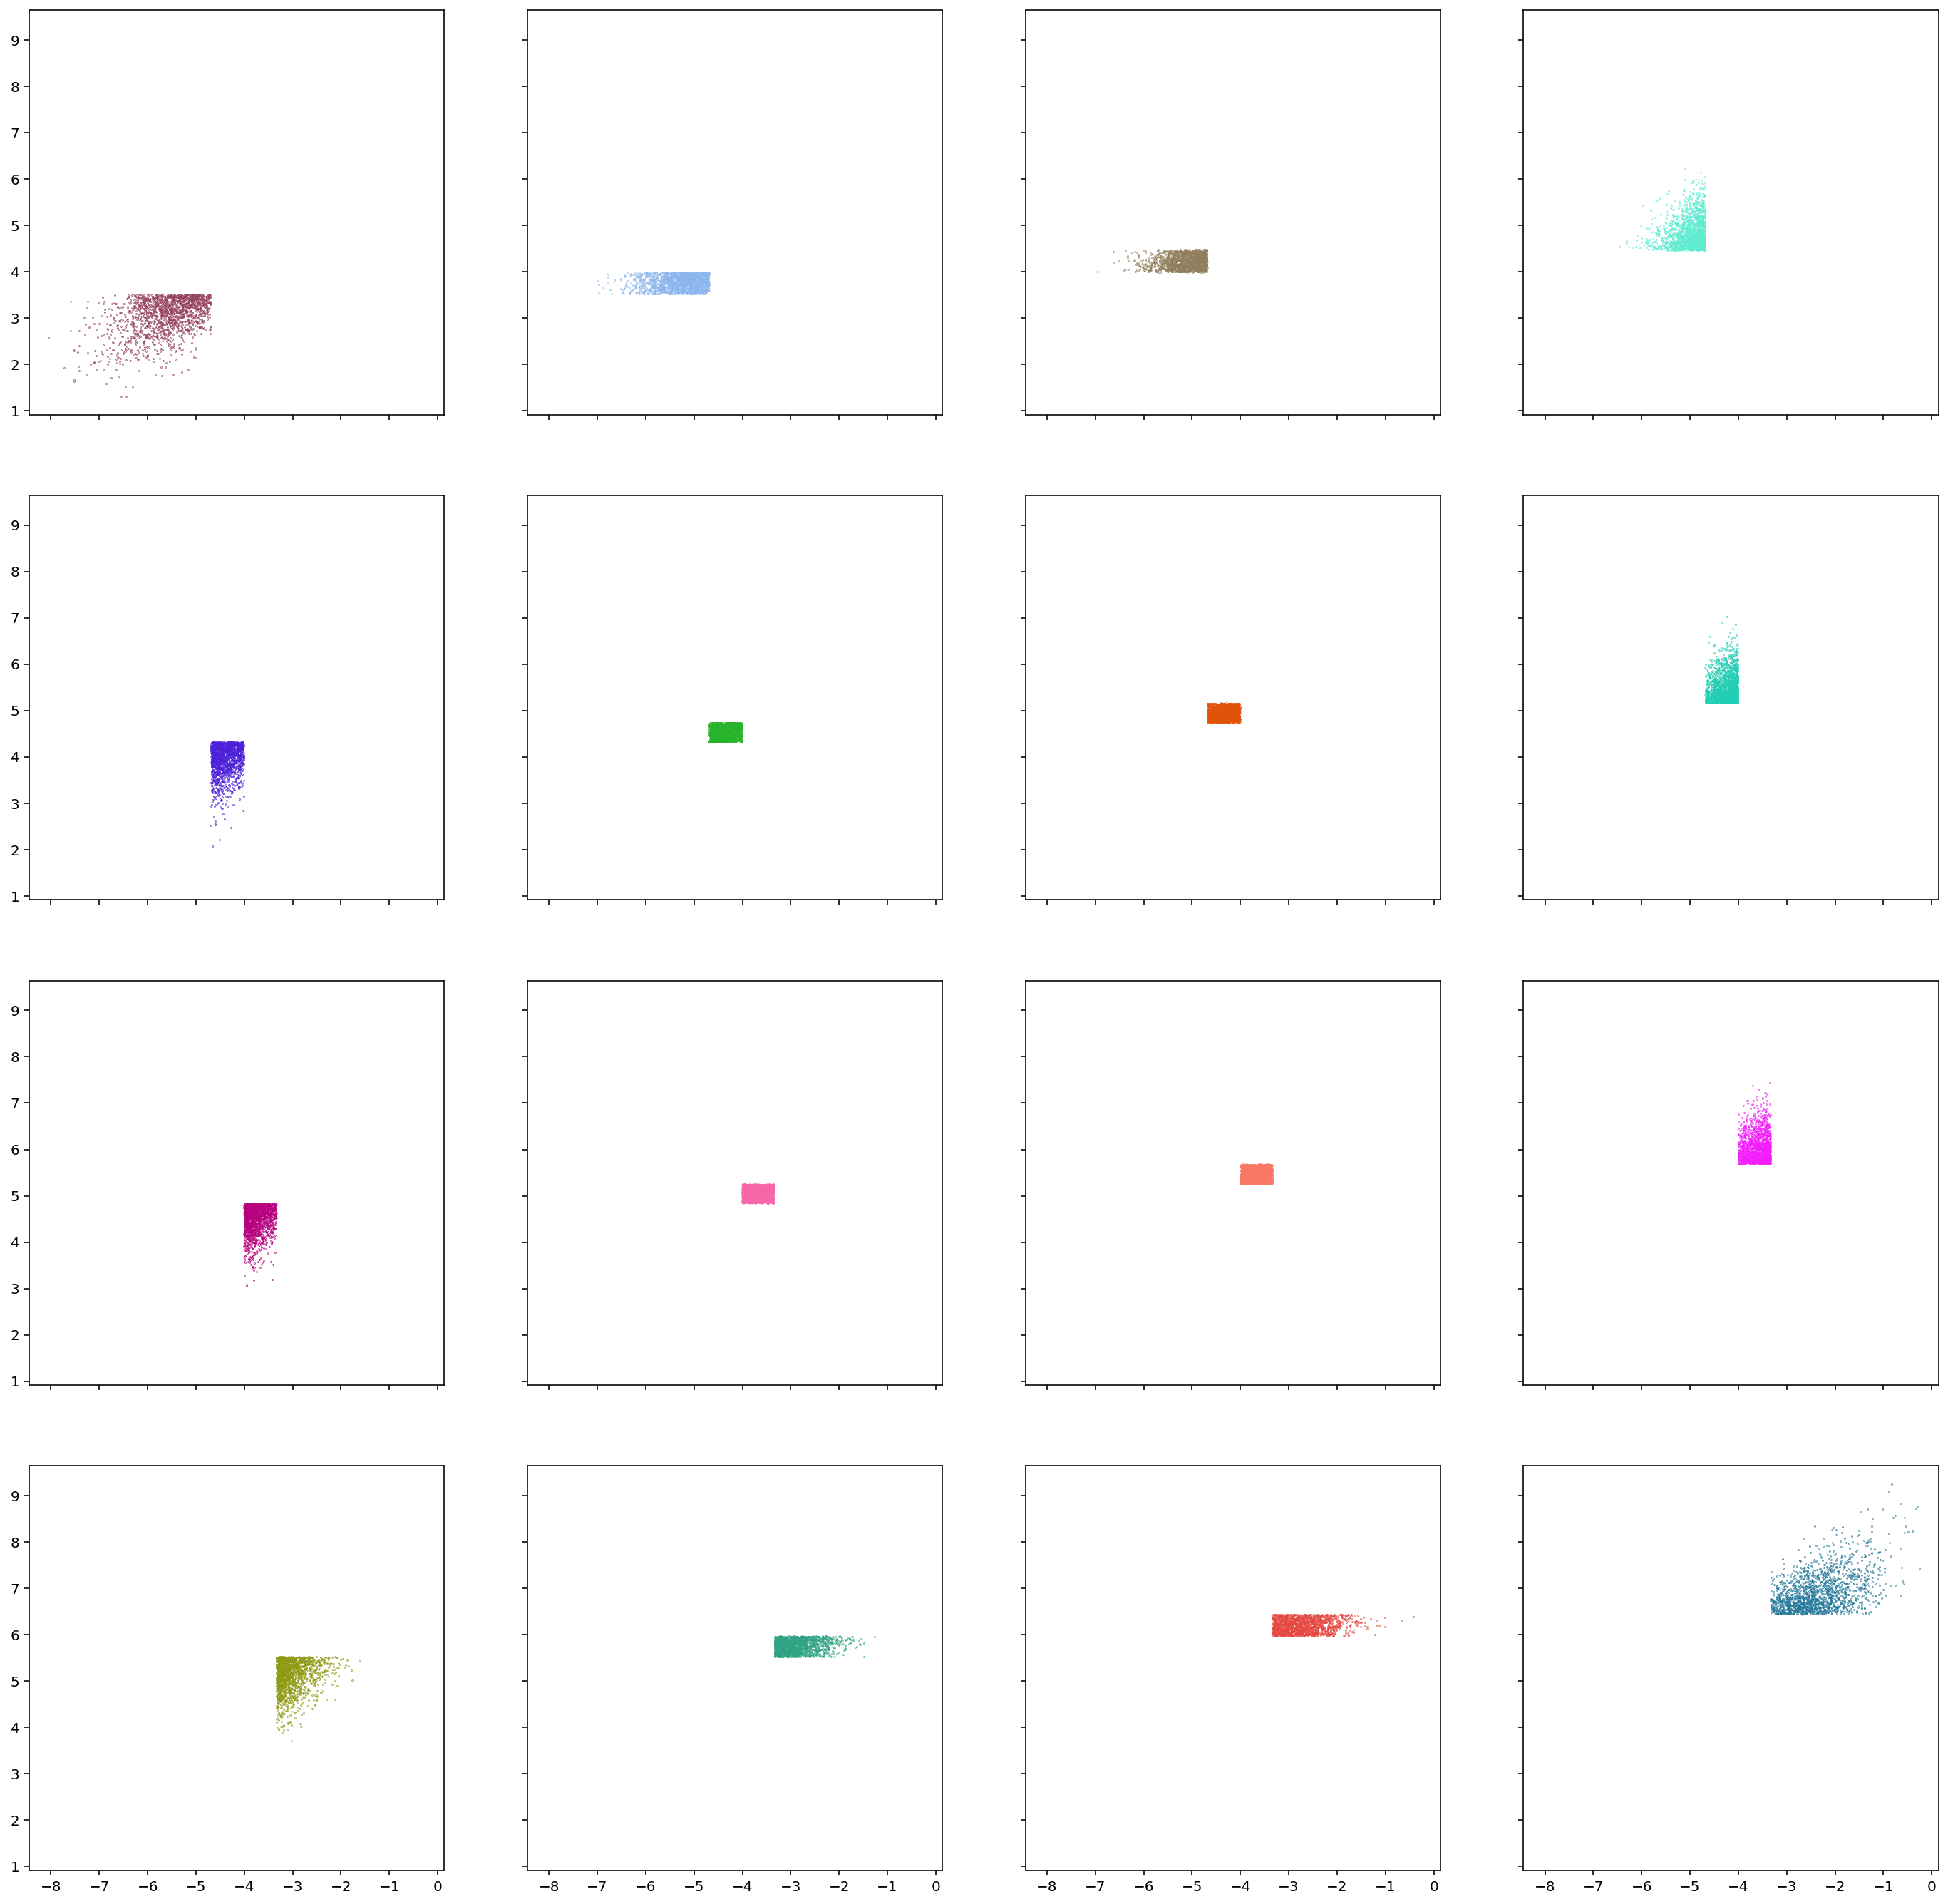

In [16]:
fig, axes = plt.subplots(n_cuts, n_cuts, figsize=(24, 24), sharex=True, sharey=True)

for i in range(n_cuts):
    pcts_x = [np.percentile(df['x'], p) for p in pcts]
    di = df[(df['x']>=pcts_x[i]) & (df['x']<=pcts_x[i+1])]
    print(i, len(di))
    pcts_y = [np.percentile(di['y'], p) for p in pcts]
    for j in range(n_cuts):
        dj = di[(di['y']>=pcts_y[j]) & (di['y']<=pcts_y[j+1])]
        nc = i * n_cuts + j
        print(i, j, nc, len(dj))
        axes[i, j].scatter(dj['x'], dj['y'], s=0.1, color=colors[nc])


plot all the blocks on the some canvas

0 6368
0 0 4 1592
0 1 4 1592
0 2 4 1592
0 3 4 1592
1 6368
1 0 4 1592
1 1 4 1592
1 2 4 1592
1 3 4 1592
2 6368
2 0 4 1592
2 1 4 1592
2 2 4 1592
2 3 4 1592
3 6368
3 0 4 1592
3 1 4 1592
3 2 4 1592
3 3 4 1592


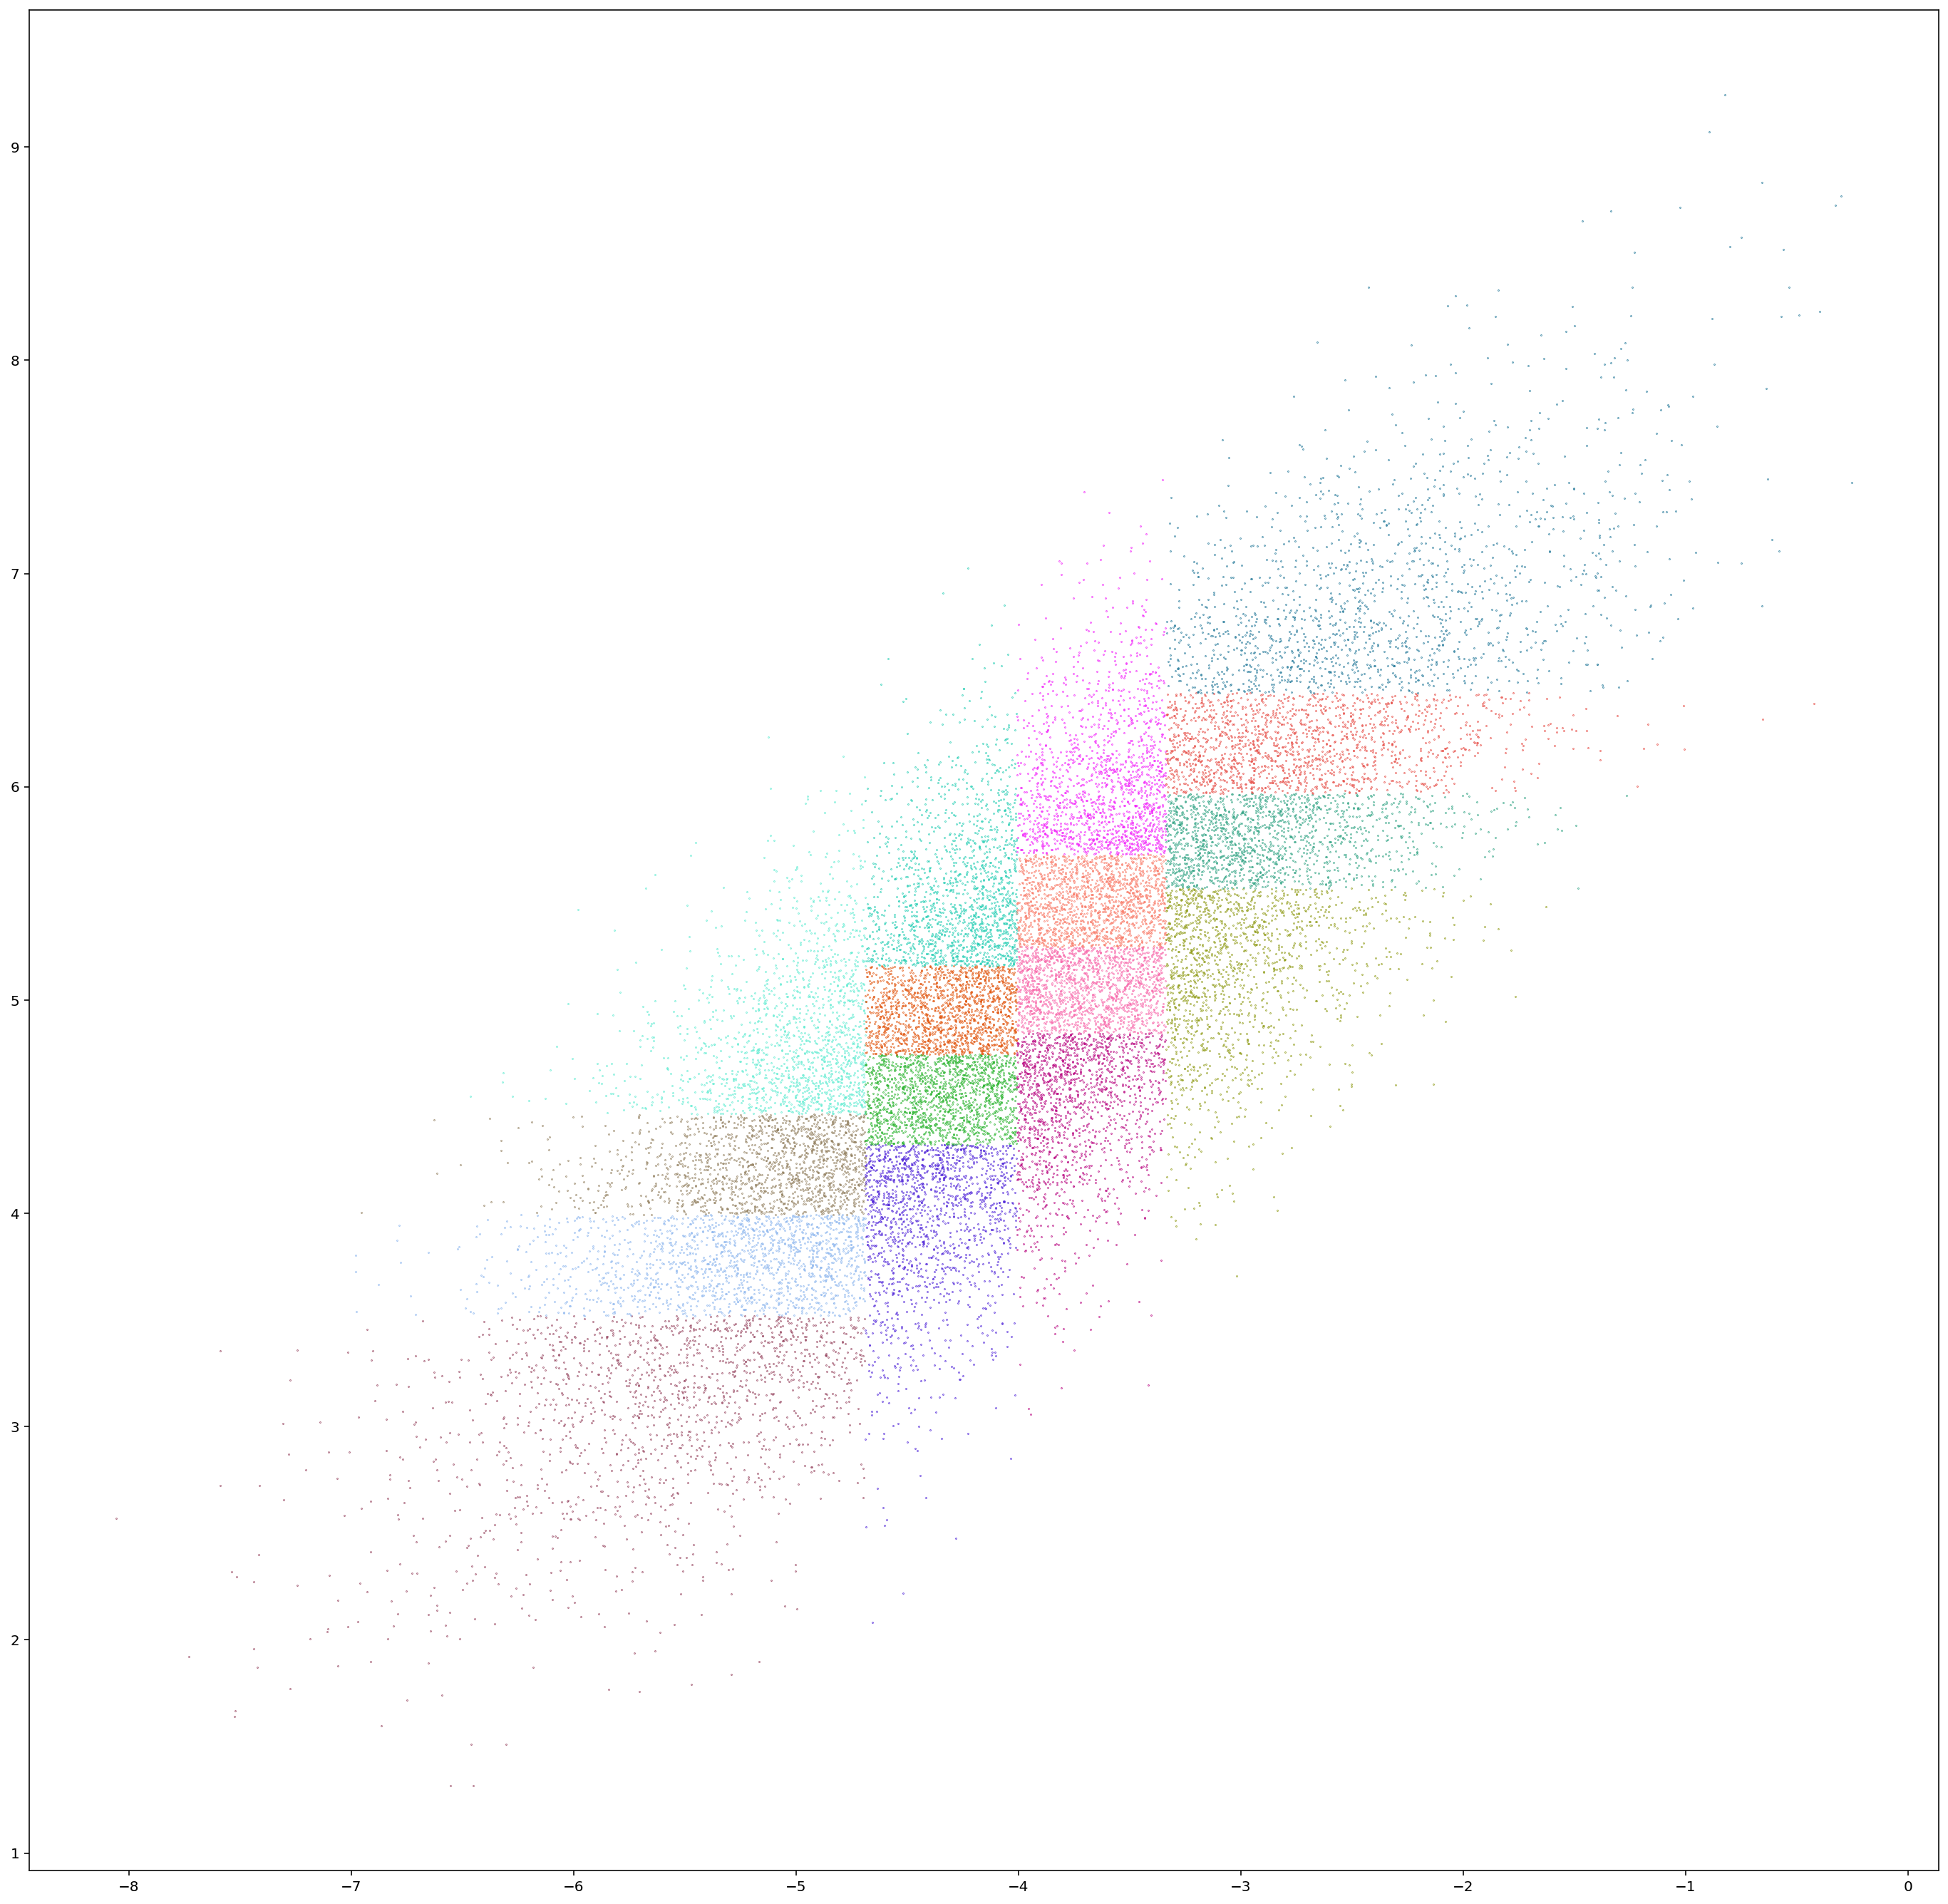

In [17]:
fig, axes = plt.subplots(figsize=(24, 24))

for i in range(n_cuts):
    pcts_x = [np.percentile(df['x'], p) for p in pcts]
    di = df[(df['x']>=pcts_x[i]) & (df['x']<=pcts_x[i+1])]
    pcts_y = [np.percentile(di['y'], p) for p in pcts]
    print(i, len(di))
    for j in range(n_cuts):
        dj = di[(di['y']>=pcts_y[j]) & (di['y']<=pcts_y[j+1])]
        nc = i * n_cuts + j
        print(i, j, n_cuts, len(dj))
        axes.scatter(dj['x'], dj['y'], s=0.1, color=colors[nc])


collect the code


In [18]:
def percentile_split(X, n_cuts=4):

    pcts = np.linspace(0, 100, n_cuts+1)
    df = pd.DataFrame(X, columns=['x', 'y'])
    ds = {}

    for i in range(n_cuts):
        pcts_x = [np.percentile(df['x'], p) for p in pcts]
        di = df[(df['x']>=pcts_x[i]) & (df['x']<=pcts_x[i+1])]
        pcts_y = [np.percentile(di['y'], p) for p in pcts]
        for j in range(n_cuts):
            dj = di[(di['y']>=pcts_y[j]) & (di['y']<=pcts_y[j+1])]
            ds[''.join([str(i), '_', str(j)])] = dj

    return ds


In [19]:
ds = percentile_split(X)

for k, v in ds.items():
    print(k, v.shape)

0_0 (1592, 2)
0_1 (1592, 2)
0_2 (1592, 2)
0_3 (1592, 2)
1_0 (1592, 2)
1_1 (1592, 2)
1_2 (1592, 2)
1_3 (1592, 2)
2_0 (1592, 2)
2_1 (1592, 2)
2_2 (1592, 2)
2_3 (1592, 2)
3_0 (1592, 2)
3_1 (1592, 2)
3_2 (1592, 2)
3_3 (1592, 2)


In [20]:
ds['0_0'].head()

,x,y
1,-6.226313,2.614249
36,-5.592859,3.137063
40,-6.091045,3.128367
68,-6.191662,3.257253
78,-6.107693,2.870360


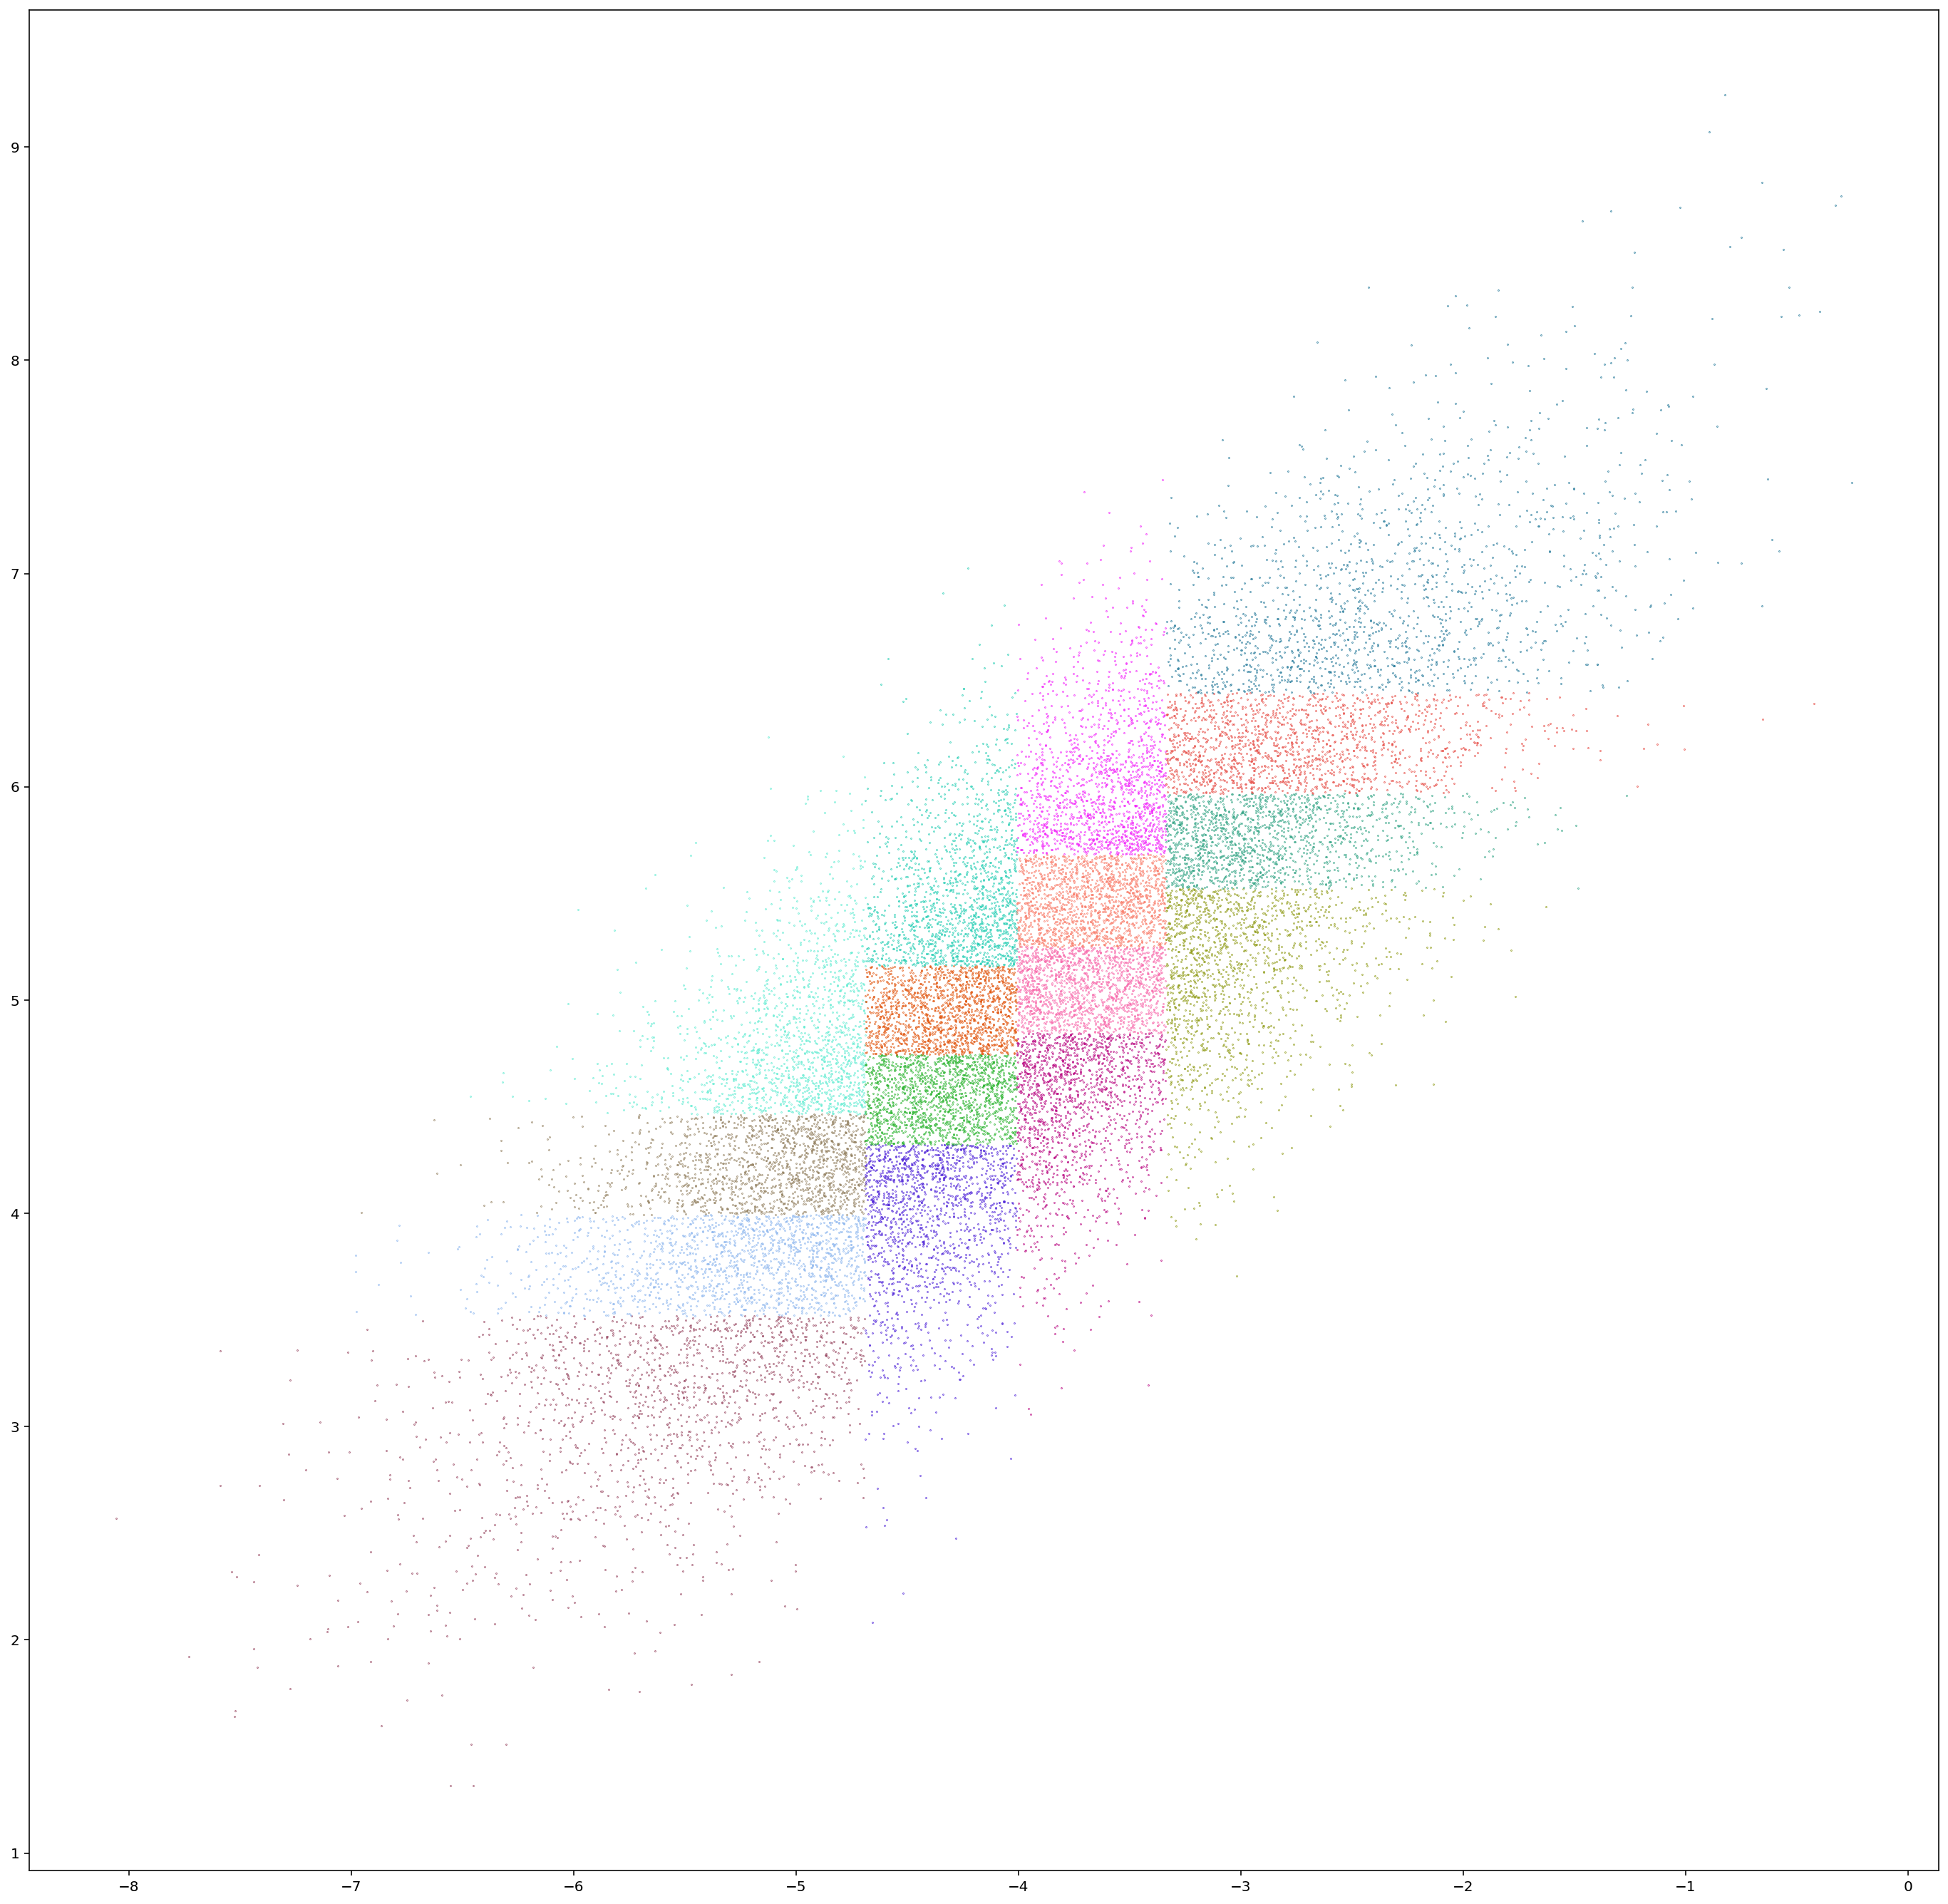

In [21]:
fig, axes = plt.subplots(figsize=(24, 24))

for i, (k, v) in enumerate(ds.items()):
#    print(i, v.shape)
    axes.scatter(v['x'], v['y'], s=0.1, color=colors[i])

test the function with different number of splits

In [22]:
n_cuts = 8
ds = percentile_split(X, n_cuts)

len(ds)

64

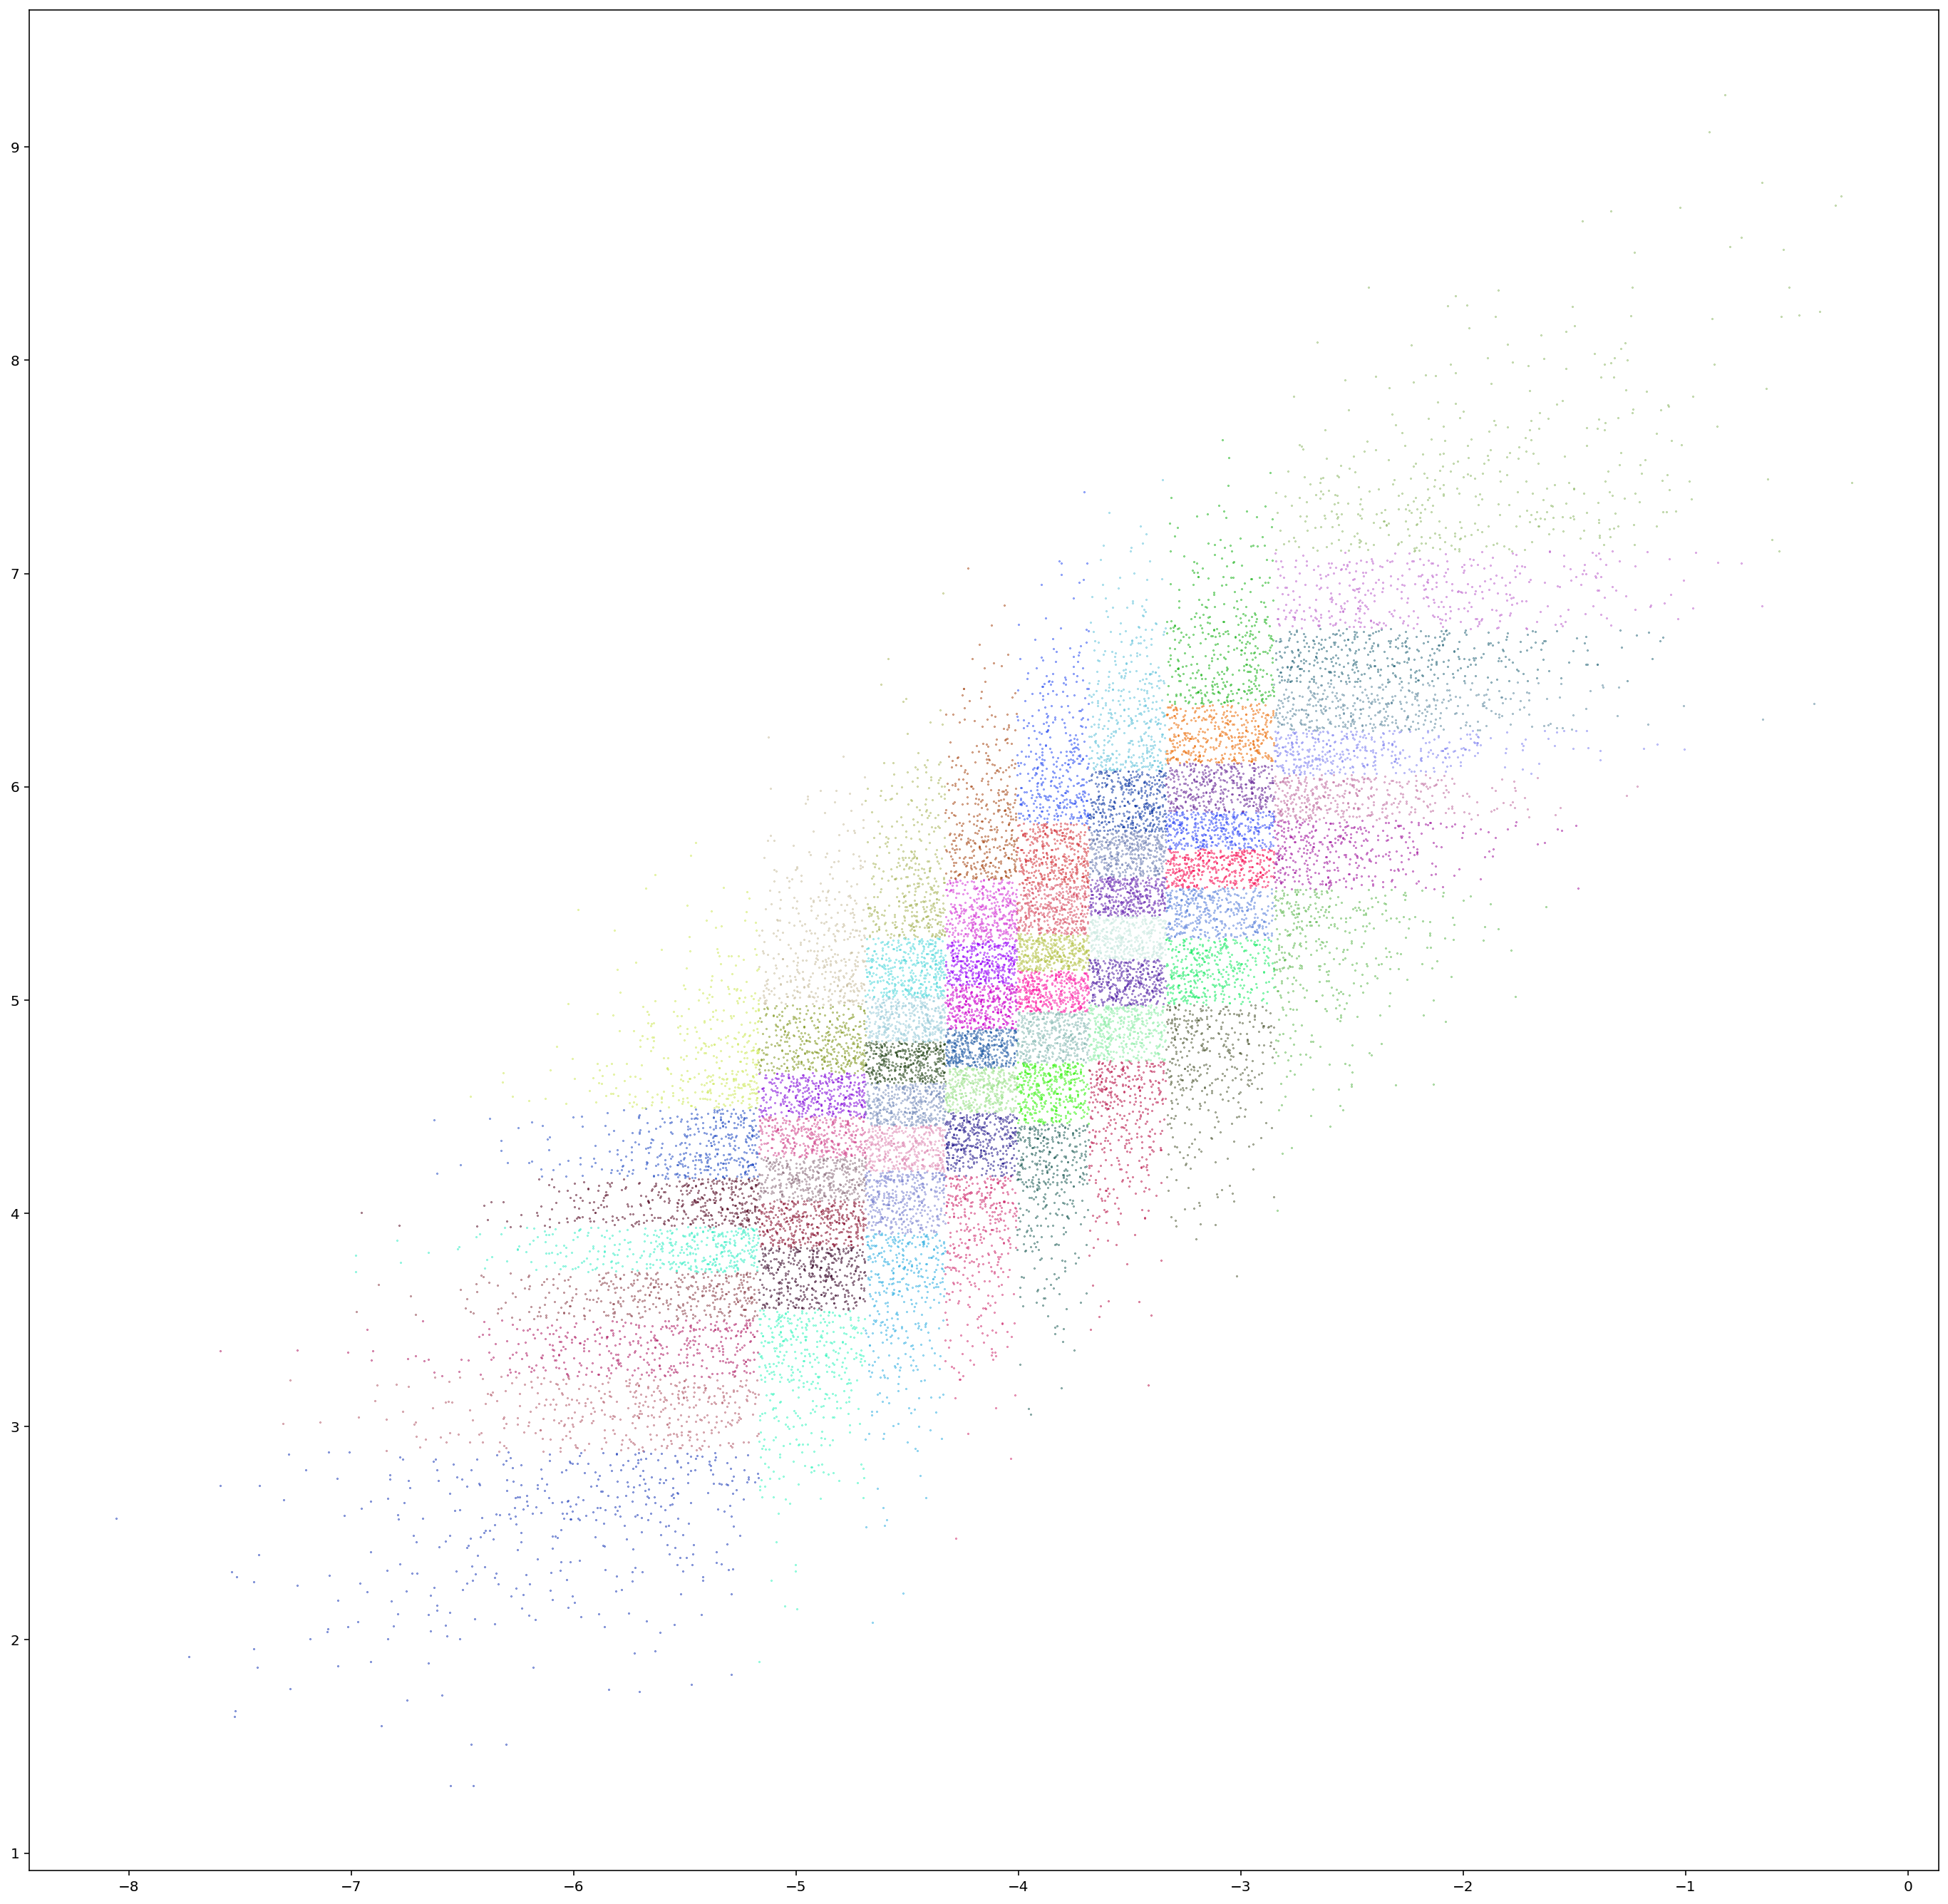

In [23]:
colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for _ in range(n_cuts**2)]
fig, axes = plt.subplots(figsize=(24, 24))

for i, (k, v) in enumerate(ds.items()):
#    print(i, v.shape)
    axes.scatter(v['x'], v['y'], s=0.1, color=colors[i])

with 100 splits, in 2 dimension this will split the data in 10 thousand blocks.

as the number of splits gets bigger and bigger, it will be more and more difficult to differentiate the individual blocks



## Doing linear assignments on individual blocks

Let's go back to a smaller number of splits and apply the lapjv algorithm on each split.

In [24]:
n_cuts = 4
ds = percentile_split(X, n_cuts)
len(ds)


16

use the grid defined by the biggest block

In [25]:
for k, v in ds.items():
    print(k, v.shape)

0_0 (1592, 2)
0_1 (1592, 2)
0_2 (1592, 2)
0_3 (1592, 2)
1_0 (1592, 2)
1_1 (1592, 2)
1_2 (1592, 2)
1_3 (1592, 2)
2_0 (1592, 2)
2_1 (1592, 2)
2_2 (1592, 2)
2_3 (1592, 2)
3_0 (1592, 2)
3_1 (1592, 2)
3_2 (1592, 2)
3_3 (1592, 2)


In [26]:
lens = [len(v) for _, v in ds.items()]
length = max(lens)

In [27]:
size1 = int(np.ceil(np.sqrt(length)))
size2 = int(np.ceil(length/size1))
grid_size = (size1, size2)


In [28]:
grid = np.dstack(np.meshgrid(np.linspace(0, 1, size2),
                             np.linspace(0, 1, size1))).reshape(-1, 2)
grid_map = grid[:length]  # non-rectangular grid


In [29]:
jvs = {}
for k, v in ds.items():
    print("Doing JV assignment on ", k)
    cost_matrix = cdist(grid_map, v, "sqeuclidean")
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid_map[col_asses]
    jvs[k] = (v, grid_jv)

print("Assignment finished")


Doing JV assignment on  0_0
Doing JV assignment on  0_1
Doing JV assignment on  0_2
Doing JV assignment on  0_3
Doing JV assignment on  1_0
Doing JV assignment on  1_1
Doing JV assignment on  1_2
Doing JV assignment on  1_3
Doing JV assignment on  2_0
Doing JV assignment on  2_1
Doing JV assignment on  2_2
Doing JV assignment on  2_3
Doing JV assignment on  3_0
Doing JV assignment on  3_1
Doing JV assignment on  3_2
Doing JV assignment on  3_3
Assignment finished


In [30]:
np.random.choice([0, 1, 2, 3], size=10)

array([1, 0, 1, 1, 2, 3, 3, 2, 2, 1])

0 0_0 (1592, 2)
1 0_1 (1592, 2)
2 0_2 (1592, 2)
3 0_3 (1592, 2)
4 1_0 (1592, 2)
5 1_1 (1592, 2)
6 1_2 (1592, 2)
7 1_3 (1592, 2)
8 2_0 (1592, 2)
9 2_1 (1592, 2)
10 2_2 (1592, 2)
11 2_3 (1592, 2)
12 3_0 (1592, 2)
13 3_1 (1592, 2)
14 3_2 (1592, 2)
15 3_3 (1592, 2)


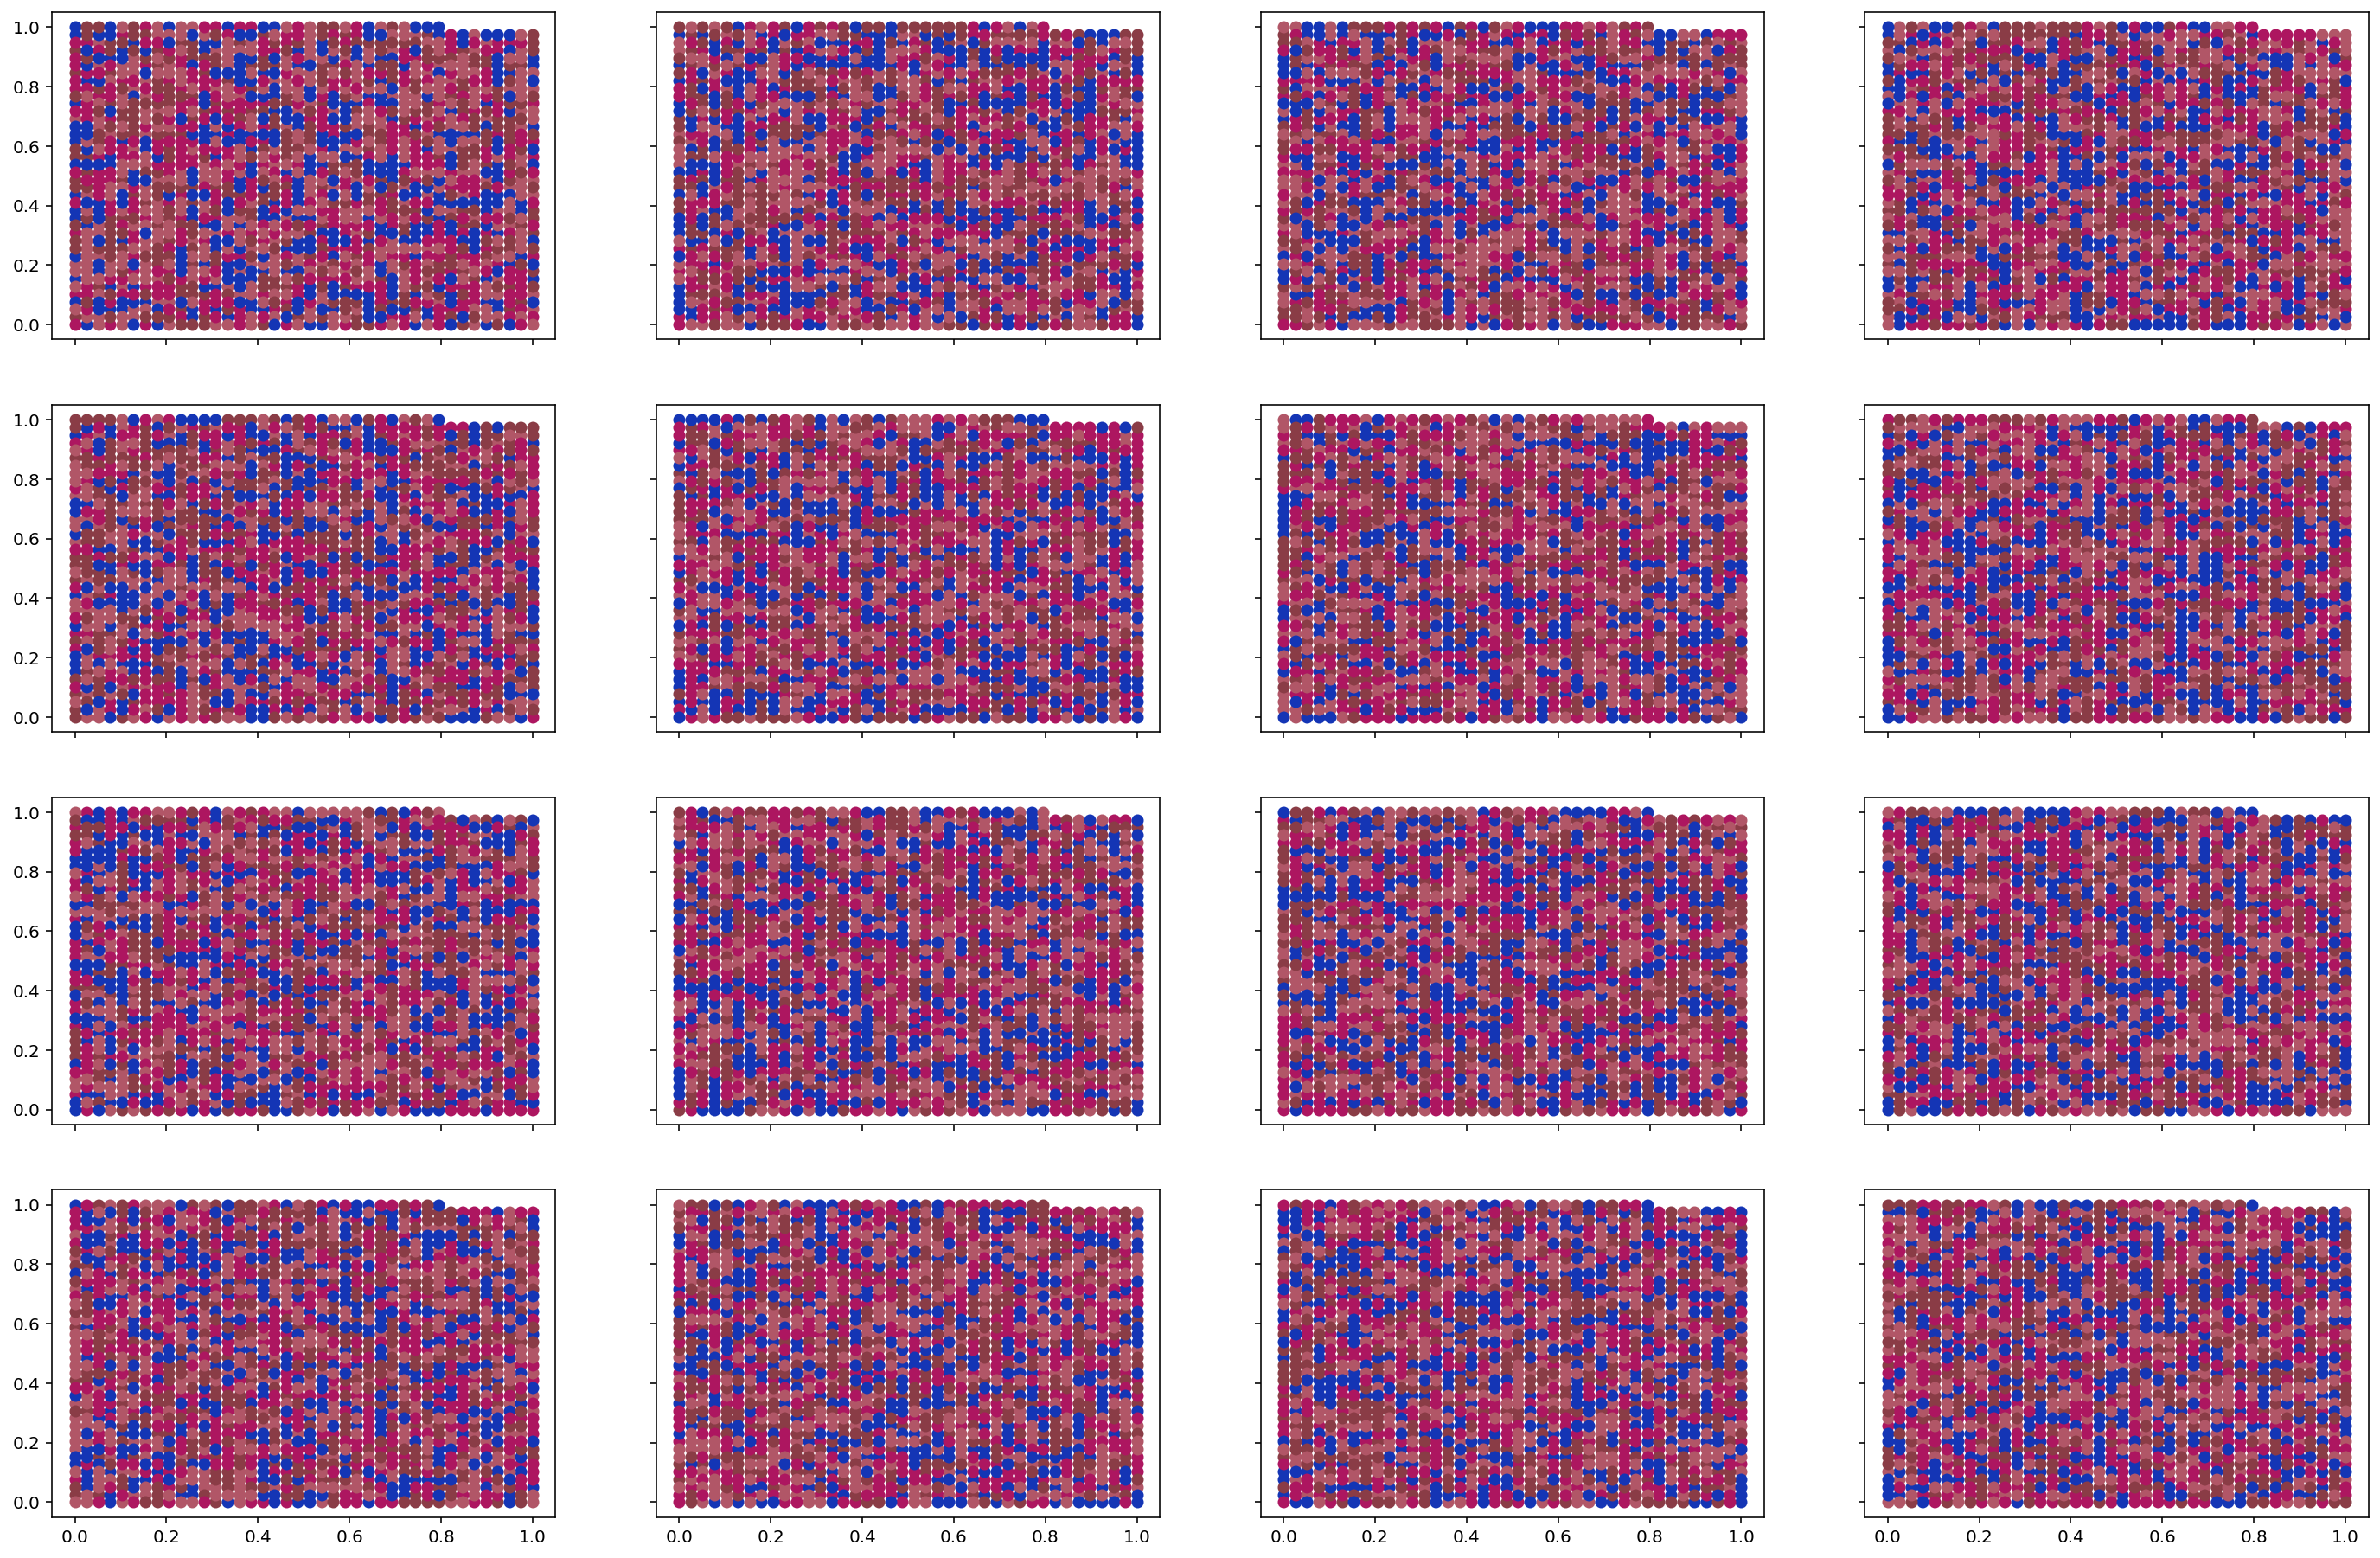

In [31]:
fig, axes = plt.subplots(n_cuts, n_cuts, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()

for i, (k, (v, grid_jv)) in enumerate(jvs.items()):
    print(i, k, v.shape)
    labels = np.random.choice([0, 1, 2, 3], size=len(v))
    for j, end in enumerate(grid_jv):
        axes[i].plot(end[0], end[1], color=colors[labels[j]], marker='o');


Finally we can collage them together.

Here the JV assignment are done sequentially in a for loop; if we have a big number of splits (10 thousand), and each block have much bigger number of data points (10 to 20 thousand data points), we'd need to parallelise them properly. 

This is what we'll do next.